In [1]:
import numpy as np
import tensorflow as tf

mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [2]:
# 将图像数据展开为向量形式
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [3]:
def softmax(x):
    x = x.astype(np.float)
    xmax = np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x - xmax)
    smax = np.sum(e_x, axis=1, keepdims=True)
    return e_x / smax


def CrossEntropy(predict, target):
    N = predict.shape[0]
    entropy = -np.log(predict[np.arange(N), target])
    return entropy

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt


class TwoLayerModel:
    def __init__(self, hidden_size, input_size=784, output_size=10, std=1e-4):
        self.params = {'W1': std * np.random.randn(input_size, hidden_size), 'b1': np.zeros(hidden_size),
                       'W2': std * np.random.randn(hidden_size, output_size), 'b2': np.zeros(output_size)}
        self.patience = 5

    def forward(self, X):
        O = {'X': X}
        Y_1 = np.dot(X, self.params['W1']) + self.params['b1']
        o_1 = 1 / (1 + np.exp(-Y_1))
        Y_2 = np.dot(o_1, self.params['W2']) + self.params['b2']
        o_2 = softmax(Y_2)
        O['Y_1'], O['o_1'], O['Y_2'], O['o_2'] = Y_1, o_1, Y_2, o_2
        return O

    def loss_grad(self, X, y, reg):
        O = self.forward(X)
        Y_1, o_1, Y_2, o_2 = O['Y_1'], O['o_1'], O['Y_2'], O['o_2']
        N = X.shape[0]
        loss = np.sum(CrossEntropy(o_2, y)) / N
        dY_2 = o_2.copy()
        dY_2[np.arange(N), y] -= 1
        dY_2 /= N

        # backward
        dW2 = np.dot(o_1.T, dY_2)
        db2 = np.sum(dY_2, axis=0)
        do_1 = np.dot(dY_2, self.params['W2'].T)
        dY_1 = np.multiply(do_1, 1 - do_1)
        dW1 = np.dot(X.T, dY_1)
        db1 = np.sum(dY_1, axis=0)
        dW2 += reg * self.params['W2']
        dW1 += reg * self.params['W1']
        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
        return loss, grads

    def train(self, X, y, reg, epochs=50, lr=0.01, batch_size=32):
        N, D = X.shape
        num_iter = N // batch_size
        avgl = []
        train_avgacc, pred_avgacc = [], []
        for epoch in range(epochs):
            L = 0
            for _ in tqdm(range(num_iter)):
                batch_indices = np.random.choice(N, batch_size, replace=True)
                X_batch = X[batch_indices]
                Y_batch = y[batch_indices]
                loss, grads = self.loss_grad(X_batch, Y_batch, reg)
                L += loss
                # 更新参数
                self.params['W1'] -= lr * grads['W1']
                self.params['b1'] -= lr * grads['b1']
                self.params['W2'] -= lr * grads['W2']
                self.params['b2'] -= lr * grads['b2']
            train_acc = (self.predict(X_train) == y_train).mean()
            pred_acc = (self.predict(X_test) == y_test).mean()
            L /= num_iter
            avgl.append(L)
            train_avgacc.append(train_acc)
            pred_avgacc.append(pred_acc)
            print(f"epoch {epoch} loss: {L}, train_acc {train_acc},pred_acc {pred_acc}")
        return avgl, train_avgacc, pred_avgacc

    def predict(self, X):
        o_2 = self.forward(X)['o_2']
        y_pred = np.argmax(o_2, axis=1)
        return y_pred

    def save(self, path):
        with open(path, 'w') as f:
            for key, value in self.params.items():
                f.write(f'{key}')
                for v in value:
                    f.write(f'{v}')
            f.write("activate function: sigmoid")

  0%|          | 0/1875 [00:00<?, ?it/s]C:/Users/99480/AppData/Local/Temp/xpython_14404/3395470305.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
C:/Users/99480/AppData/Local/Temp/xpython_14404/2727000714.py:14: RuntimeWarning: overflow encountered in exp
  o_1 = 1 / (1 + np.exp(-Y_1))
100%|##########| 1875/1875 [00:03<00:00, 502.32it/s]


epoch 0 loss: 1.0869370769975104, train_acc 0.81475,pred_acc 0.8169


100%|##########| 1875/1875 [00:03<00:00, 608.20it/s]


epoch 1 loss: 0.6471395128759813, train_acc 0.8216666666666667,pred_acc 0.8284


100%|##########| 1875/1875 [00:03<00:00, 602.53it/s]


epoch 2 loss: 0.585145360907861, train_acc 0.8358833333333333,pred_acc 0.8443


100%|##########| 1875/1875 [00:03<00:00, 506.41it/s]


epoch 3 loss: 0.5351022956935952, train_acc 0.84565,pred_acc 0.8514


100%|##########| 1875/1875 [00:03<00:00, 539.72it/s]


epoch 4 loss: 0.5079473324749899, train_acc 0.8521166666666666,pred_acc 0.857


100%|##########| 1875/1875 [00:03<00:00, 560.88it/s]


epoch 5 loss: 0.5036791582770911, train_acc 0.8554666666666667,pred_acc 0.8626


100%|##########| 1875/1875 [00:02<00:00, 819.69it/s]


epoch 6 loss: 0.48665698148923076, train_acc 0.8579,pred_acc 0.8623


100%|##########| 1875/1875 [00:02<00:00, 757.41it/s]


epoch 7 loss: 0.48360323812415573, train_acc 0.8596166666666667,pred_acc 0.8645


100%|##########| 1875/1875 [00:02<00:00, 655.75it/s]


epoch 8 loss: 0.4760161204490632, train_acc 0.8625833333333334,pred_acc 0.8686


100%|##########| 1875/1875 [00:02<00:00, 680.29it/s]


epoch 9 loss: 0.4742553238939607, train_acc 0.8616,pred_acc 0.8691


100%|##########| 1875/1875 [00:02<00:00, 693.13it/s]


epoch 10 loss: 0.4753264650852602, train_acc 0.8606666666666667,pred_acc 0.8687


100%|##########| 1875/1875 [00:02<00:00, 759.35it/s]


epoch 11 loss: 0.467925995932359, train_acc 0.8598166666666667,pred_acc 0.8675


100%|##########| 1875/1875 [00:02<00:00, 753.61it/s]


epoch 12 loss: 0.46371350591019517, train_acc 0.8618,pred_acc 0.8685


100%|##########| 1875/1875 [00:03<00:00, 513.52it/s]


epoch 13 loss: 0.46161607451968595, train_acc 0.8627333333333334,pred_acc 0.8677


100%|##########| 1875/1875 [00:03<00:00, 497.81it/s]


epoch 14 loss: 0.45809482593662854, train_acc 0.8629,pred_acc 0.8689


100%|##########| 1875/1875 [00:03<00:00, 528.92it/s]


epoch 15 loss: 0.4511413456581405, train_acc 0.8621166666666666,pred_acc 0.8689


100%|##########| 1875/1875 [00:02<00:00, 783.70it/s]


epoch 16 loss: 0.46507396335148826, train_acc 0.8625,pred_acc 0.87


100%|##########| 1875/1875 [00:03<00:00, 605.16it/s]


epoch 17 loss: 0.4491157472949139, train_acc 0.8634833333333334,pred_acc 0.8704


100%|##########| 1875/1875 [00:02<00:00, 766.50it/s]


epoch 18 loss: 0.4592555246687692, train_acc 0.8629666666666667,pred_acc 0.8717


100%|##########| 1875/1875 [00:03<00:00, 498.43it/s]


epoch 19 loss: 0.4554383351543623, train_acc 0.8634,pred_acc 0.8712


100%|##########| 1875/1875 [00:03<00:00, 498.74it/s]


epoch 20 loss: 0.45689569641450506, train_acc 0.86575,pred_acc 0.8769


100%|##########| 1875/1875 [00:03<00:00, 548.93it/s]


epoch 21 loss: 0.45040357573995227, train_acc 0.8660833333333333,pred_acc 0.8751


100%|##########| 1875/1875 [00:03<00:00, 514.94it/s]


epoch 22 loss: 0.4499162464928837, train_acc 0.8663166666666666,pred_acc 0.8749


100%|##########| 1875/1875 [00:04<00:00, 468.32it/s]


epoch 23 loss: 0.4534919619758651, train_acc 0.8658666666666667,pred_acc 0.8763


100%|##########| 1875/1875 [00:03<00:00, 501.76it/s]


epoch 24 loss: 0.44521706859800836, train_acc 0.8646666666666667,pred_acc 0.8752


100%|##########| 1875/1875 [00:03<00:00, 504.67it/s]


epoch 25 loss: 0.4482213695825683, train_acc 0.86635,pred_acc 0.8768


100%|##########| 1875/1875 [00:02<00:00, 715.78it/s]


epoch 26 loss: 0.44429181311490096, train_acc 0.8662833333333333,pred_acc 0.8751


100%|##########| 1875/1875 [00:03<00:00, 499.09it/s]


epoch 27 loss: 0.4417703504554394, train_acc 0.8661166666666666,pred_acc 0.8732


100%|##########| 1875/1875 [00:03<00:00, 507.72it/s]


epoch 28 loss: 0.4397042526923814, train_acc 0.8676166666666667,pred_acc 0.8748


100%|##########| 1875/1875 [00:03<00:00, 483.11it/s]


epoch 29 loss: 0.4392836937545063, train_acc 0.8697,pred_acc 0.8785


100%|##########| 1875/1875 [00:03<00:00, 599.42it/s]


epoch 30 loss: 0.4318341510066626, train_acc 0.8707666666666667,pred_acc 0.8781


100%|##########| 1875/1875 [00:03<00:00, 594.01it/s]


epoch 31 loss: 0.4336927585115559, train_acc 0.8713666666666666,pred_acc 0.8812


100%|##########| 1875/1875 [00:03<00:00, 526.87it/s]


epoch 32 loss: 0.4362724957908407, train_acc 0.8728166666666667,pred_acc 0.8789


100%|##########| 1875/1875 [00:03<00:00, 512.15it/s]


epoch 33 loss: 0.4271682409600467, train_acc 0.87305,pred_acc 0.8779


100%|##########| 1875/1875 [00:02<00:00, 634.94it/s]


epoch 34 loss: 0.42880063444699806, train_acc 0.8742166666666666,pred_acc 0.8797


100%|##########| 1875/1875 [00:02<00:00, 720.59it/s]


epoch 35 loss: 0.4282594047926376, train_acc 0.87455,pred_acc 0.8811


100%|##########| 1875/1875 [00:02<00:00, 728.79it/s]


epoch 36 loss: 0.4202299220769818, train_acc 0.87565,pred_acc 0.884


100%|##########| 1875/1875 [00:02<00:00, 714.30it/s]


epoch 37 loss: 0.41758517864695016, train_acc 0.8755166666666667,pred_acc 0.8815


100%|##########| 1875/1875 [00:02<00:00, 716.52it/s]


epoch 38 loss: 0.4219267236502387, train_acc 0.8764666666666666,pred_acc 0.8838


100%|##########| 1875/1875 [00:02<00:00, 753.28it/s]


epoch 39 loss: 0.4161200078808215, train_acc 0.8770833333333333,pred_acc 0.8849


100%|##########| 1875/1875 [00:02<00:00, 741.71it/s]


epoch 40 loss: 0.41544342909369697, train_acc 0.8760833333333333,pred_acc 0.884


100%|##########| 1875/1875 [00:02<00:00, 732.79it/s]


epoch 41 loss: 0.410137299814347, train_acc 0.8781333333333333,pred_acc 0.8854


100%|##########| 1875/1875 [00:02<00:00, 684.82it/s]


epoch 42 loss: 0.4075341167177839, train_acc 0.8749666666666667,pred_acc 0.8829


100%|##########| 1875/1875 [00:02<00:00, 701.48it/s]


epoch 43 loss: 0.41351763531530766, train_acc 0.8751,pred_acc 0.883


100%|##########| 1875/1875 [00:02<00:00, 689.23it/s]


epoch 44 loss: 0.41107754832404175, train_acc 0.87535,pred_acc 0.8834


100%|##########| 1875/1875 [00:02<00:00, 677.56it/s]


epoch 45 loss: 0.4091265938478616, train_acc 0.8752333333333333,pred_acc 0.8854


100%|##########| 1875/1875 [00:02<00:00, 694.05it/s]


epoch 46 loss: 0.4147697363455032, train_acc 0.8746333333333334,pred_acc 0.8859


100%|##########| 1875/1875 [00:02<00:00, 706.75it/s]


epoch 47 loss: 0.40789571281209097, train_acc 0.875,pred_acc 0.8849


100%|##########| 1875/1875 [00:02<00:00, 687.37it/s]


epoch 48 loss: 0.4070110905441731, train_acc 0.8761666666666666,pred_acc 0.8833


100%|##########| 1875/1875 [00:02<00:00, 690.99it/s]


epoch 49 loss: 0.404770706469975, train_acc 0.8758833333333333,pred_acc 0.8844


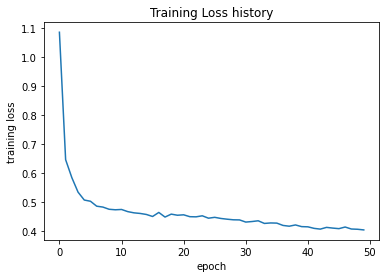

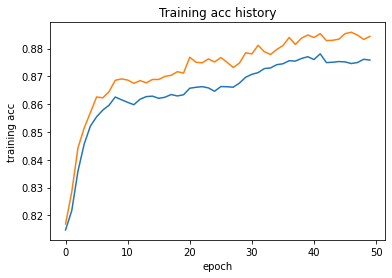

In [5]:
model = TwoLayerModel(128)
L, train_acc, pred_acc = model.train(X_train, y_train, reg=1e-4)
plt.plot(L)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()
plt.plot(train_acc)
plt.plot(pred_acc)
plt.xlabel('epoch')
plt.ylabel('training acc')
plt.title('Training acc history')
plt.show()

In [6]:
predict = model.predict(X_test)
test_acc = (predict == y_test).mean()
print(f"acc:{test_acc}")

C:/Users/99480/AppData/Local/Temp/xpython_14404/2727000714.py:14: RuntimeWarning: overflow encountered in exp
  o_1 = 1 / (1 + np.exp(-Y_1))
C:/Users/99480/AppData/Local/Temp/xpython_14404/3395470305.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)


acc:0.8844


In [11]:
model.save('model.txt')

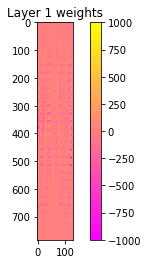

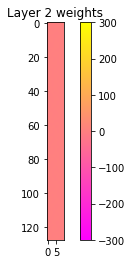

In [8]:
plt.figure(1)
plt.imshow(model.params['W1'], cmap='spring', vmin=-1000, vmax=1000)
plt.title('Layer 1 weights')
plt.colorbar()
plt.show()
plt.figure(1)
plt.imshow(model.params['W2'], cmap='spring', vmin=-300, vmax=300)
plt.title('Layer 2 weights')
plt.colorbar()
plt.show()